In [3]:
import pandas as pd 
import re
import string
import json

from bs4 import BeautifulSoup
import codecs
import numpy as np
import matplotlib.pyplot as plt
import requests

import nltk
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import pymorphy2
from tqdm import tqdm
from collections import Counter

from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
plt.style.use('seaborn')

## Идея 1
#### Признаки - расстояния до ближайших заголовков других страниц из группы

Возьмем данные о заголовках веб-страниц, которые использовали до этого в домашней работе

In [5]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


Получим информацию о группах веб-страниц

In [6]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        groups_train.append(new_group)
groups_train = np.array(groups_train)
print(groups_train.shape)

(11690,)


Добавим нулевой документ для удобства работы

In [7]:
doc_to_title[0] = ''

Переведем строчку в список слов

In [8]:
doc_to_title_list = {id_: title.lower().split()
                     for id_, title in doc_to_title.items()}

Произведем векторизацию

In [9]:
tfidf_vectorizer_1 = TfidfVectorizer()

lst = [' '.join(doc_to_title_list[i]) for i in range(len(doc_to_title_list))]

doc_tfidf_1 = tfidf_vectorizer_1.fit_transform(lst)

doc_tfidf_1.shape

(28027, 41736)

Непосредственно приготавливаем наши признаки, которые представляют косинусное расстояние до 20 ближайших документов

In [10]:
df = pd.read_csv('train_groups.csv')
groups = df.groupby('group_id')
global_index = 0
X_1 = np.empty((df.shape[0], 20), dtype=float)
y = np.empty(df.shape[0], dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_1[group.doc_id], metric='cosine')):
        X_1[global_index + index] = sorted(distances)[1:21]
    y[global_index:size_of_group+global_index] = group.target
    global_index += size_of_group
X_1.shape, y.shape

((11690, 20), (11690,))

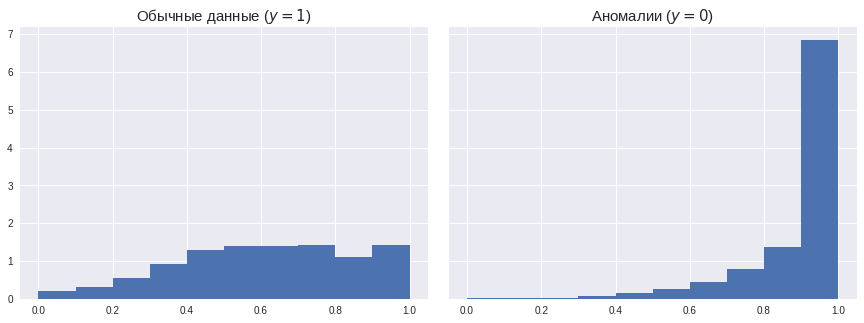

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].hist(np.concatenate(X_1[np.where(y == 1)]), label='$y=1$', density=True)
axes[0].set_title('Обычные данные ($y=1$)', fontsize=15)
axes[1].hist(np.concatenate(X_1[np.where(y == 0)]), label='$y=0$', density=True)
axes[1].set_title('Аномалии ($y=0$)', fontsize=15)
plt.subplots_adjust(wspace=0.05)

Видно, распределения аболютно отличаются, а значит наши признаки позволят нам отличить информацию

Делаем тоже самое для тестовой части, разумеется, исключая таргет

In [14]:
df = pd.read_csv('test_groups.csv')
groups = df.groupby('group_id')
global_index = 0
count = 0
X_test_1 = np.empty((df.shape[0], 20), dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_1[group.doc_id], metric='cosine')):
        X_test_1[global_index + index] = sorted(distances)[1:21]
    global_index += size_of_group
X_test_1.shape

(16627, 20)

Отнормируем наши данные

In [15]:
scaler = StandardScaler()

X_train_1_scaled = scaler.fit_transform(X_1)

В качестве классификатора используем градиентный бустинг, который достаточно наивным образом попробуюм затюнить

In [16]:
param_grid_XGB = {'learning_rate': [.01, .03, .05, .1, .25],
                  'max_depth': [1, 2, 4, 6, 8, 10],
                  'n_estimators': [10, 50, 100, 300],
                  'seed': [0]}

xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(xgb, param_grid_XGB, scoring=make_scorer(f1_score), cv=GroupKFold(
    n_splits=5))

grid_search_xgb.fit(X_train_1_scaled, y, groups=groups_train)

xgb_best = grid_search_xgb.best_estimator_

grid_search_xgb.best_params_

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:44] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:26:53] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:53] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:54] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:54] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:27:23] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:28] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:28:42] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:49] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:02] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:02] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:30:11] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:12] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:14] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:15] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:31:29] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:29] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:30] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:30] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:31:46] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:49] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:50] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:53] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:32:28] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:28] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:29] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:30] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:33:31] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:34] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:41] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:45] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:35:15] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:39] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:50] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:36:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:07] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:36:30] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:31] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:33] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:37:15] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:18] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:24] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:31] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:38:55] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:57] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:40:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:26] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:40:38] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:39] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:40] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:41] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:41:20] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:24] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:28] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:28] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:42:20] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:20] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:22] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:23] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:43:36] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:40] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:44] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:47] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:44:54] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:55] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:57] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:45:19] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:19] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:19] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:20] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:45:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:57] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:58] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:59] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:46:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:59] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:16] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[16:48:55] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10, 'seed': 0}

Посмотрим качество f1 на валидации

In [19]:
cross_val_score(xgb_best, X_train_1_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:33] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:33] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:33] WARNING: /tmp/pip-build-tajdlzuo/xgboo

0.7197891267592494

Зафитим наши данные

In [22]:
xgb_best.fit(X_train_1_scaled, y)

[16:49:45] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Подготовим тестовые данные

In [23]:
X_test_1_scaled = scaler.transform(X_test_1)

In [24]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

Сабмитим резалт

In [27]:
def submit(clf):
    y_pred = clf.predict(X_test_1_scaled)

    y_pred = y_pred.astype(int)

    answer = pd.DataFrame({'pair_id': np.asarray(
        test_data['pair_id']), 'target': y_pred})

    answer = answer.set_index(['pair_id'])

    answer.to_csv('sub.csv')

In [28]:
submit(xgb_best)

Скор на тесте - 0.70693

## Идея 2
#### Признаки - расстояния до ближайших текстов других страниц из группы

Обработка данных...

In [29]:
def is_ru_alpha(tested_string):
    match = re.match("^[а-яА-Я]+$", tested_string)
    return match is not None

In [30]:
def dump_to_file(path, file_name, my_list):
    with open(path + '/' + file_name + '.txt', 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)

In [31]:
def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]

In [32]:
def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens

In [33]:
def tokenize_n_lemmatize(text, stopwords=True, normalize=True):
    if normalize:
        words = normalize_tokens(text)
    if stopwords:
        words = remove_stopwords(words, stopwords)
    return words

In [34]:
def get_url_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')

In [35]:
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"
stopwords_ru = get_url_text(url_stopwords_ru).splitlines()

Получаем корпус

In [36]:
def get_corpus(corpus=None, load_path='content/', start_page=1, finish_page=28027):
    """
    Возвращает корпус(dict) всех слов
    """
    if finish_page>28027:
        return
    
    vocabulary = []
    if corpus:
        result = corpus
    else:
        result = dict()
    filetail = '.dat'
        
    with tqdm(total=finish_page-start_page) as pbar:
        for page_num in range(start_page, finish_page): # 1, 28027
            with codecs.open(load_path + str(page_num) + filetail, 'r', 'utf-8') as f:
                content = BeautifulSoup(f, 'lxml').text
                content = re.sub(r'\n', ' ', content)
                content = re.sub(r'\t', ' ', content)

            for word in content.split():
                word = word.translate(str.maketrans(' ', ' ', string.punctuation))
                if is_ru_alpha(word):
                    vocabulary.append(word.lower())
            
            words = tokenize_n_lemmatize(vocabulary, stopwords=stopwords_ru)
            for word in words:
                if word in result:
                    result[word] += 1
                else:
                    result[word] = 1
            vocabulary = []
                    
            pbar.update(1)
    
    return result

In [37]:
# corpus = get_corpus(None, 'content/', 1, 28027)
# with open('corpus_1.txt', 'w', encoding='utf-8') as file:
#     file.write(json.dumps(corpus))

In [38]:
with open('corpus.txt', 'r', encoding='utf-8') as file:
    json_corp = file.read()
    corpus = json.loads(json_corp)

Подготавливаем корпус

In [39]:
iter_corpus = list(corpus.keys())
len(iter_corpus)

915849

Делаем лишнюю работу - обрабатываем тексты

In [40]:
def rewrite_file(page_num):
    load_path='content/'
    filetail = '.dat'
    with codecs.open(load_path + str(page_num) + filetail, 'r', 'utf-8') as f:
        content = BeautifulSoup(f, 'lxml').text
        content = re.sub(r'\n', ' ', content)
        content = re.sub(r'\t', ' ', content)

    text = []
    for word in content.split():
        word = word.translate(str.maketrans(' ', ' ', string.punctuation))
        text.append(word)
    words = tokenize_n_lemmatize(text, stopwords=stopwords_ru)
    
    save_path='/media/dmitry/EXT SSD/clean_content/'
    save_filetail = '.txt'
    with open(save_path + 'text_' + str(page_num) + save_filetail, 'w') as f:
        f.write(' '.join(words))

In [41]:
def rewr_files(start_page=1, finish_page=28027):
    with tqdm(total=finish_page-start_page) as pbar:
        for page_num in range(start_page, finish_page): # 1, 28027
            rewrite_file(page_num)
            pbar.update(1)

In [42]:
# rewr_files(1, 23027)

Пустой нулевой документ для удобства

In [44]:
with open('/media/dmitry/EXT SSD/clean_content/text_0.txt', 'w') as f:
    f.write('')

Готовим данные для векторайзера

In [45]:
file_list = [f'/media/dmitry/EXT SSD/clean_content/text_{_i}.txt' for _i in range(0, 28027)]

In [46]:
tfidf_corpus = {key:val for key, val in corpus.items() if val>1}

In [47]:
tfidf_corpus = list(tfidf_corpus.keys())

In [48]:
len(tfidf_corpus)

915849

Векторизуем

In [49]:
vectorizer_2 = TfidfVectorizer(input='filename', vocabulary=tfidf_corpus, max_df=0.25)

In [51]:
doc_tfidf_2 = vectorizer_2.fit_transform(file_list)

In [52]:
df = pd.read_csv('train_groups.csv')
groups = df.groupby('group_id')
global_index = 0
X_2 = np.empty((df.shape[0], 20), dtype=float)
y = np.empty(df.shape[0], dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_2[group.doc_id], metric='cosine')):
        X_2[global_index + index] = sorted(distances)[1:21]
    y[global_index:size_of_group+global_index] = group.target
    global_index += size_of_group
X_2.shape, y.shape

((11690, 20), (11690,))

Посмотрим на распределение

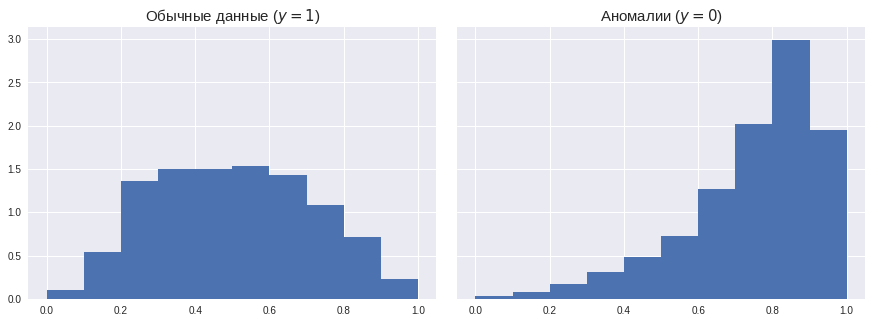

In [54]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].hist(np.concatenate(X_2[np.where(y == 1)]), label='$y=1$', density=True)
axes[0].set_title('Обычные данные ($y=1$)', fontsize=15)
axes[1].hist(np.concatenate(X_2[np.where(y == 0)]), label='$y=0$', density=True)
axes[1].set_title('Аномалии ($y=0$)', fontsize=15)
plt.subplots_adjust(wspace=0.05)

То же с тестовыми данными

In [55]:
df = pd.read_csv('test_groups.csv')
groups = df.groupby('group_id')
global_index = 0
count = 0
X_test_2 = np.empty((df.shape[0], 20), dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_2[group.doc_id], metric='cosine')):
        X_test_2[global_index + index] = sorted(distances)[1:21]
    global_index += size_of_group
X_test_2.shape

(16627, 20)

Отнормируем наши данные

In [56]:
scaler = StandardScaler()

In [57]:
X_train_2_scaled = scaler.fit_transform(X_2)
X_test_2_scaled = scaler.transform(X_test_2)

Xgboost...

In [58]:
param_grid_XGB = {'learning_rate': [.01, .03, .05, .1, .25],
                  'max_depth': [1, 2, 4, 6, 8, 10],
                  'n_estimators': [10, 50, 100, 300],
                  'seed': [0]}

xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(xgb, param_grid_XGB, scoring=make_scorer(f1_score), cv=GroupKFold(
    n_splits=5))

grid_search_xgb.fit(X_train_2_scaled, y, groups=groups_train)

xgb_best = grid_search_xgb.best_estimator_

grid_search_xgb.best_params_

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:49] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:49] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:49] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:49] WARNING: /tmp/pip-build-tajdlzuo/xgboo

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10, 'seed': 0}

In [59]:
cross_val_score(xgb_best, X_train_2_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:56] WARNING: /tmp/pip-build-tajdlzuo/xgboo

0.6275944268275719

In [73]:
def submit(clf):
    y_pred = clf.predict(X_test_2_scaled)

    y_pred = y_pred.astype(int)

    answer = pd.DataFrame({'pair_id': np.asarray(
        test_data['pair_id']), 'target': y_pred})

    answer = answer.set_index(['pair_id'])

    answer.to_csv('sub_2.csv')

In [60]:
submit(xgb_best)

Скор на тесте - 0.62303

## Идея 3 
#### Используем все признаки из Идеи 1 и Идеи 2
Мы обязательно выиграем...

Train:

In [61]:
df = pd.read_csv('train_groups.csv')
groups = df.groupby('group_id')
global_index = 0
X = np.empty((df.shape[0], 40), dtype=float)
y = np.empty(df.shape[0], dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_1[group.doc_id], metric='cosine')):
        X[global_index + index][:20] = sorted(distances)[1:21]
    y[global_index:size_of_group+global_index] = group.target
    global_index += size_of_group
X.shape, y.shape

((11690, 40), (11690,))

In [62]:
global_index = 0
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_2[group.doc_id], metric='cosine')):
        X[global_index + index][20:] = sorted(distances)[1:21]
    y[global_index:size_of_group+global_index] = group.target
    global_index += size_of_group
X.shape, y.shape

((11690, 40), (11690,))

Test:

In [63]:
df = pd.read_csv('test_groups.csv')
groups = df.groupby('group_id')
global_index = 0
count = 0
X_test = np.empty((df.shape[0], 40), dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_1[group.doc_id], metric='cosine')):
        X_test[global_index + index][:20] = sorted(distances)[1:21]
    global_index += size_of_group
X_test.shape

(16627, 40)

In [64]:
global_index = 0
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf_2[group.doc_id], metric='cosine')):
        X_test[global_index + index][20:] = sorted(distances)[1:21]
    global_index += size_of_group
X_test.shape

(16627, 40)

Отнормируем наши данные

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

Xgboost...

In [67]:
param_grid_XGB = {'learning_rate': [0.005],#[.005, .01, .03, .05, .1],
                  'max_depth': [1],#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'n_estimators': [5],#[5, 10, 30, 50, 75, 100, 200, 300],
                  'seed': [0]}

xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(xgb, param_grid_XGB, scoring=make_scorer(f1_score), cv=GroupKFold(
    n_splits=5))

grid_search_xgb.fit(X, y, groups=groups_train)

xgb_best = grid_search_xgb.best_estimator_

grid_search_xgb.best_params_

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:24] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:24] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:24] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:24] WARNING: /tmp/pip-build-tajdlzuo/xgboo

{'learning_rate': 0.005, 'max_depth': 1, 'n_estimators': 5, 'seed': 0}

In [68]:
cross_val_score(xgb_best, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:28] WARNING: /tmp/pip-build-tajdlzuo/xgboo

0.7237126969428611

Что-то напоминает..

In [69]:
xgb_best.fit(X_train_scaled, y)

[16:59:34] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [74]:
def submit(clf):
    y_pred = clf.predict(X_test_scaled)

    y_pred = y_pred.astype(int)

    answer = pd.DataFrame({'pair_id': np.asarray(
        test_data['pair_id']), 'target': y_pred})

    answer = answer.set_index(['pair_id'])

    answer.to_csv('sub_3.csv')

In [75]:
submit(xgb_best)

Скор на тесте - 0.70693

Что-то не так - смотрим важность признаков

In [70]:
from xgboost import plot_importance

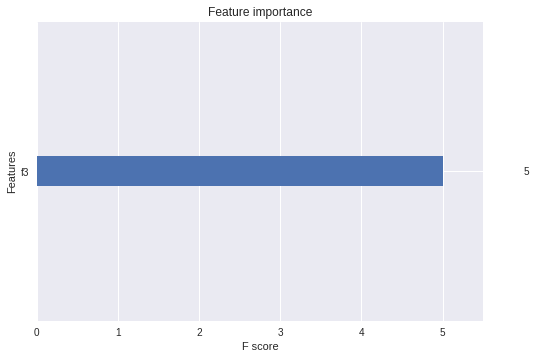

In [71]:
plot_importance(xgb_best)
plt.show()

Получается, наша лучшая модель использует только расстояние( между заголовками ) до 17-го по удаленности сайта

### Пробуем построить модель по-лучше...

In [83]:
test_xgb = XGBClassifier(learning_rate=0.01, max_depth=8, n_estimators=100)

In [84]:
test_xgb.fit(X_train_scaled, y)

[17:10:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Посмотрим важность признаков теперь

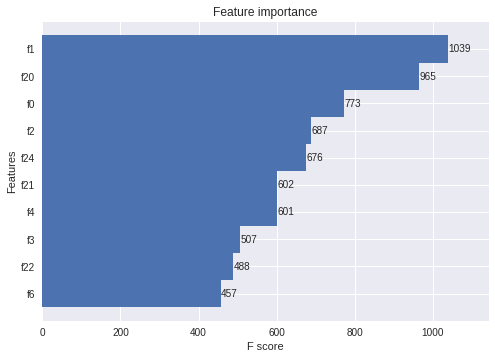

In [85]:
plot_importance(test_xgb, height=1, max_num_features=10)
plt.show()

Теперь получаем результаты, которые поддаются интерпретации

In [86]:
cross_val_score(test_xgb, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:35] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:41] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:45] WARNING: /tmp/pip-build-tajdlzuo/xgboo

0.7012508843501501

In [89]:
submit(test_xgb)

Скор на тесте - 0.69873

#### Лог регрессия ?

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
test_logreg = LogisticRegression(max_iter=1000)

In [95]:
test_logreg.fit(X_train_scaled, y)

LogisticRegression(max_iter=1000)

In [96]:
cross_val_score(test_logreg, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

0.6973134489469877

In [97]:
submit(test_logreg)

Скор на тесте - 0.68821

#### Random forest ?

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
test_rfc = RandomForestClassifier(n_estimators=1000)

In [102]:
test_rfc.fit(X_train_scaled, y)

RandomForestClassifier(n_estimators=1000)

In [103]:
cross_val_score(test_rfc, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

0.7040940285640986

In [106]:
submit(test_rfc)

Скор на тесте - 0.70332

#### Стекинг ?

In [107]:
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier

In [109]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('bxgb', xgb_best),
    ('xgb', XGBClassifier(learning_rate=0.01, max_depth=8, n_estimators=100)),
    ('adb', AdaBoostClassifier(n_estimators=100)),
]

In [110]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [111]:
clf.fit(X, y)

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:14] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:14] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:45] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:45] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:45] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:45] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:51] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:03] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:09] WARNING: /tmp/pip-build-tajdlzuo/xgboo

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('bxgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.005,
                                              max_delta_step=0, max_depth=1,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n...
                                              max_delta_step=None, max_depth=8,
                         

In [112]:
cross_val_score(clf, X, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:44] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:44] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:11] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:11] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:11] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:11] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:11] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:16] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:21] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:25] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:56] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:22] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:22] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:22] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:22] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:22] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:26] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:31] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:36] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:32] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:18] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:18] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:42] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:43] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:26] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:26] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:53] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:53] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:53] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:53] WARNING: /tmp/pip-build-tajdlzuo/xgboo

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:53] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:57] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:02] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:06] WARNING: /tmp/pip-build-tajdlzuo/xgboo

0.6955523035491348

In [113]:
submit(clf)

Скор на тесте - 0.53490 